In [17]:
%run tools.ipynb
np.set_printoptions(suppress = True)

In [47]:

class etkf():
    '''class of Ensemble Kalman Filter'''
    def __init__(self, xm, prior_err, ym, mod_err, obs, obs_err, del_y0):
        '''Initialisation
        Arguments: 
            xm [nx]: state variables
            prior_err [nx]: a priori error
            ym [nobs]: y modeled
            mod_err [nobs]: model/transport error + represenation error
            obs [nobs]: y measured
            obs_err [nobs]: measurement error
            del_y0 [nobs,nx]: perturbed y modeled, by turning on one state variable at a time
        '''
        self.xm = np.diag(xm)
        self.pri_err = np.diag(prior_err)
        self.ym = ym
        self.obs = obs
        self.mod_err = np.diag(mod_err)
        self.obs_err = np.diag(obs_err)
        self.del_y0 = del_y0
        
        # get attributes:
        self.nx = len(self.xm)
        self.nobs = len(self.obs)
        
        # some calculations:
        self.del_y0_t = np.matrix.transpose(self.del_y0)     # del_y transpose [nx,nobs]
    
    def get_bias(self):
        self.bias = self.obs - self.ym 
        return self.bias
    
    def get_R(self):
        '''R matrix'''
        self.r = self.mod_err**2 + self.obs_err**2
        self.sqr=np.diag(np.sqrt(self.r)) # R^0.5, diagonal, sparce matrix, aviod doing inverse of matrix

    def get_svd(self):
        '''SVD decomposition'''
        self.get_R()
        self.scyt=self.del_y0_t/self.sqr # the scaled y=r^-0.5*y ==>scaled yt=yt*r^-0.5
        print('shape of scaled y transpose: ', np.shape(self.scyt))
        self.uy, self.wy, self.vyt=np.linalg.svd(self.scyt) # decomposition of tranpose(scaled_y)
        print('SVD decomposition matrices: ')
        print('uy: ', np.shape(self.uy))
        print('wy: ', np.shape(self.wy)) # only 1-dim, non-zero, due to python function
        print('vyt: ', np.shape(self.vyt))
        
        self.md=1.0/(1.0+self.wy*self.wy) #  1d array of min[ny, nx]
        print('self.md: ', np.shape(self.md))
        # in calculation of  K , we need 1.0/(1.0+w*wt)  of [nobs, nobs]
        # in calculation of transform matrix, we need 1.0/(1.0+wt*w) of [ne, ne]
        self.uw=self.uy*self.wy
        print('uw: ', np.shape(self.uw))
    
    def get_tm(self):
        """ the analysis increment on the variables  
                Arguments:
                    None
                Returns:
                    tm   :   matrix of [nx, nx] for transform from X'(f)--> X'(a)      
                Notes: 
                    tm=U*(1+W*WT)^-0.5)*UT
                    tm = self.uy * self.md * self.uyt
        """  
        self.get_svd()
        inv_s = np.ones(self.nx, float)
        inv_s = np.sqrt(self.md)
        tm = self.uy * inv_s
        tm = np.dot(tm, np.transpose(self.uy))
        print('-'*8+"etkf: xtm, analysis increment on the variables"+'-'*8)
        print(np.shape(tm))
        return tm
    
    #def get_k_l(self):
        """ calculate analysis gain k matrix 
            Arguments:
                None
            Returns: 
                k matrix    :   array of [nobs, nobs]=[ny, ny]
            Notes:
                K=X'*U*W*(I+WT*W)^-1*VT*R^-0.5
        """
    #    self.get_svd()
    #    inv_s=np.ones(self.nobs, float) # filled with one 
    #    inv_s[0:self.nx]=self.md[0:self.nx]
        
    #    uw_nx, uw_ny=np.shape(self.uw)
    #    rny=self.nobs
    #    if (uw_ny<rny):
    #        rny=uw_ny
        
    #    y_inv=self.uw[:,0:rny]*inv_s[0:rny]
    #    y_inv_v=np.dot(y_inv, self.vyt[0:rny, :]) #dimension of [ne, ny]
    #    print('y_inv_v:', np.shape(y_inv_v))
    #    self.k=np.dot(self.xm, y_inv_v)  # dimension [nx, nx] x [nx, ny]
    #    self.k=self.k/self.sqr
    #    print('k: ', np.shape(self.k))
    #    return self.k
    
    #def get_inc_m(self):
    #    '''analysis increment'''
    #    self.get_k_l()
    #    dy = self.get_bias()
    #    dy = dy/self.sqr
    #    xinc = np.dot(self.k,dy)
    #    print('xinc: ', xinc)
    #    print('global update: ', sum(xinc))
    #    return xinc
    
    def get_k(self):
        first      = np.matmul(self.del_y0,self.del_y0_t) # del_y dot del_y_tran [nobs,nobs]
        self.get_R()
        second     = np.linalg.inv(first+self.r) # (Y*Yt + R)^-1 [nobs,nobs]
        self.third = np.matmul(self.del_y0_t,second) # Yt*(Y*Yt + R)^-1 [nx,nobs]
        self.k     = np.matmul(self.pri_err,self.third) # kalman gain, k_e = X_f*Yt*(Y*Yt + R)^-1 [nx,nobs]
        
    def get_adjust(self):
        dy = self.get_bias()
        self.get_k()
        self.adjust = np.matmul(self.k, dy)     # adjustment to prior, k_e*(yobs - ym)  [nx]
        print('adjust: ', np.shape(self.adjust))
        return self.adjust
    
    #def get_transform(self):
    #    self.transform = np.identity(22) - np.matmul(self.third, self.del_y0)
        
    #def get_update(self):
    #    self.get_k()
    #    self.get_transform()
    #    self.post_err = np.dot(self.pri_err, self.transform)
    #    print('updated error: ', np.shape(self.post_err))
    #    return self.post_err
    

In [48]:
imonth = 3
top_dir = '/geos/u73/msadiq/GEOS-Chem/rundirs/ensemble_runs/'
mod_dir = top_dir + 'CO2-2018/nd51/'

name_month = short_name_of_month(imonth)
ens_dir = top_dir + 'CO2-2018-' + month_string(imonth) + '/nd51/'

delta_y0_file = 'delta_y0_model_N_' + str(imonth) + '.nc'
xco2_file = 'XCO2_mod_and_oco2_N_' + name_month + '.nc'
# open datasets
# ensemble runs
ds_delta_y0 = xr.open_dataset(ens_dir + delta_y0_file)
varnames = list(ds_delta_y0.data_vars.keys())  # list of variable name
needed_vars = [i for i in varnames if i.startswith('X_SpeciesConc_CO2Tag')] # species var names
# one-year run
ds_xco2 = xr.open_dataset(mod_dir + xco2_file)
xco2_oco2  = ds_xco2['xco2_oco2']
xco2_model = ds_xco2['xco2_model']
xco2_error = ds_xco2['xco2_error']
diff = ds_xco2['xco2_oco2'] - ds_xco2['xco2_model']
# reduce the size of all arrays and matrices, from 400k to <10k
x = xco2_oco2.copy()
x = x[np.logical_not(np.isnan(x))]
ind = x.record.values   # index for slicing
length = len(ind)
# get a slice of arrays
diff_slice = diff[ind].values            # [nobs], 1-3k per month
xco2_error_slice = xco2_error[ind].values
obs_slice = ds_xco2['xco2_oco2'][ind].values
ym_slice = ds_xco2['xco2_model'][ind].values

# settings
nx = 22
nobs = len(ym_slice)
pri_error = 0.2
mod_error = 0.5

prior_err = np.repeat(pri_error,nx)
mod_err = np.repeat(mod_error,nobs)
net_flux_2018 = np.array([1.67560978, 1.21305357, 1.11566443, 0.45897526, -0.70416052,
       -1.50918113, -0.83657388,0.39889446, 1.20208357, 1.55320872,
        1.59745675, 1.98040347])

# delta y0
del_y0 = np.zeros((nobs,nx))   # [nobs, nx]
for itag, ivar in enumerate(needed_vars):
    del_y0[:,itag] = ds_delta_y0[ivar][ind].values
 
# monthly net flux monthly, calculated in emission directory
monthly_net_flux = np.array([[-0.0064147 ,  0.07445906, -0.10581314,  0.02305773,  0.23837679,
         0.26386957,  0.22911544,  0.07728346,  0.09897539,  0.28756375,
         0.36633632,  0.15041014,  0.12210651, -0.11564749,  0.01955141,
        -0.0105203 ,  0.63860122,  0.03680348,  0.14569273,  0.04243613,
         0.59434582,  0.12670701],
       [ 0.04448958,  0.00888961, -0.17399979,  0.01047562,  0.16182761,
         0.1841661 ,  0.17366136,  0.05500812,  0.0761485 ,  0.15790085,
         0.29273754,  0.19235391,  0.09473187, -0.19723211,  0.01438183,
         0.01754501,  0.47276133,  0.04281528,  0.08758799,  0.032275  ,
         0.45819631,  0.02629607],
       [-0.03904325, -0.05196531, -0.11004996,  0.03000899,  0.11329988,
         0.09688519,  0.10803165,  0.06161624,  0.07695003, -0.00312003,
         0.30056612,  0.19386702,  0.02736085, -0.21489142,  0.01570047,
         0.04379239,  0.4192146 ,  0.28369713,  0.01071397,  0.03408788,
         0.51244586,  0.0163498 ],
       [-0.02628382, -0.02097708, -0.00737329,  0.06662067, -0.00122051,
        -0.12723264, -0.0457352 ,  0.0488416 ,  0.02293675, -0.27178127,
         0.04589279,  0.16248327,  0.00108851, -0.14597134,  0.01211855,
         0.06315739,  0.24290746,  0.35614459, -0.14091845,  0.02348104,
         0.30512951, -0.09968819],
       [ 0.01803107,  0.06984216,  0.09025795,  0.10887096, -0.17634585,
        -0.29912442, -0.22012879, -0.02873586, -0.05275236, -0.44417846,
        -0.49636077,  0.07047011, -0.05433822, -0.04425672,  0.01468228,
         0.10753403,  0.01532049,  0.306318  , -0.25781675, -0.01484554,
        -0.55475842, -0.3318801 ],
       [ 0.03995982, -0.06950229,  0.11725599,  0.04820313, -0.40792831,
        -0.30416459, -0.25926141, -0.20413501, -0.19508879, -0.28472521,
        -0.80160416,  0.00745161, -0.00904155,  0.01500956,  0.01618913,
         0.03840942, -0.03336745,  0.15003075, -0.10201374, -0.07068423,
        -1.67339447, -0.47641225],
       [ 0.01919811, -0.13490034,  0.13805936, -0.06298192, -0.35390222,
        -0.22020304, -0.1449531 , -0.2389173 , -0.24942657,  0.01482722,
        -0.41795171, -0.10537141, -0.03199819,  0.03777135,  0.01839562,
         0.013893  , -0.03404708, -0.05481413,  0.02240025, -0.12022424,
        -1.60681926, -0.44811588],
       [-0.04738685, -0.06603833,  0.08814858, -0.07085706, -0.13035064,
        -0.00201846, -0.10774618, -0.06712404, -0.1601901 ,  0.18746224,
        -0.12796772, -0.19822794, -0.08612231,  0.09084938,  0.01896059,
         0.00562349, -0.04031761, -0.14982693,  0.06003547, -0.07982452,
        -0.68527422, -0.14865125],
       [-0.12247829,  0.35941432,  0.00956134, -0.07055113,  0.01727857,
         0.05087755,  0.03502709,  0.08565843,  0.01044127,  0.0565928 ,
         0.07822011, -0.28711585, -0.14011593,  0.16050157,  0.01689712,
        -0.00525722,  0.18342855, -0.19903888,  0.02404396, -0.00651329,
         0.49605621,  0.13702924],
       [-0.079821  ,  0.38125308, -0.12648625, -0.04260378,  0.15606699,
         0.15009308,  0.14922913,  0.10465625,  0.09993308,  0.16801607,
         0.37892645, -0.23910852, -0.05656457,  0.15449727,  0.01785115,
         0.00288898,  0.39971869, -0.08488195,  0.07219775,  0.04648412,
         0.788445  ,  0.24200536],
       [ 0.00492083,  0.17452221, -0.14297589,  0.01400184,  0.2341404 ,
         0.22236434,  0.19735325,  0.08273484,  0.10635675,  0.2291097 ,
         0.3974018 , -0.08010411,  0.01700091,  0.05300111,  0.01697323,
        -0.00615702,  0.52703348,  0.00569335,  0.11545969,  0.04592113,
         0.6768642 ,  0.16645794],
       [-0.00754005,  0.07385957, -0.10638479,  0.02398443,  0.2386446 ,
         0.26386957,  0.23146184,  0.07645549,  0.09311629,  0.28755643,
         0.36601319,  0.1502165 ,  0.12151426, -0.12053466,  0.01953446,
        -0.00870257,  0.64087145,  0.03658765,  0.14569273,  0.04243613,
         0.59196113,  0.11088942]])


In [49]:
env = etkf(monthly_net_flux[imonth - 1,:], #net_flux_2018, xm, should be [22,1] of net/ff co2 fluxes for each region, right?
           prior_err, 
           ym_slice, 
           mod_err, 
           obs_slice, 
           xco2_error_slice, 
           del_y0)


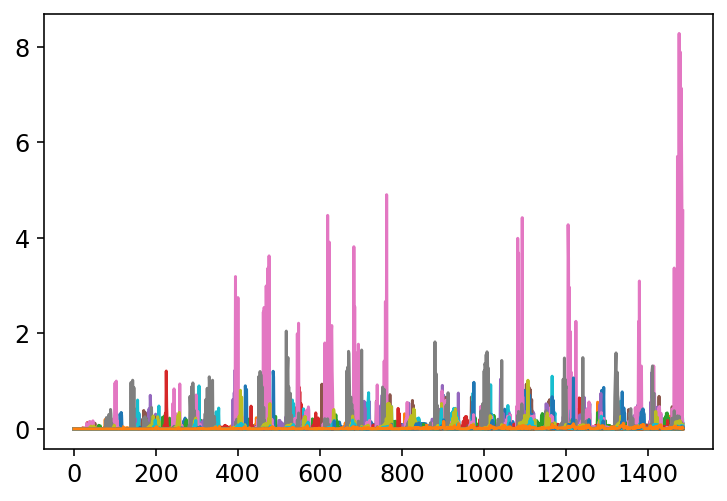

In [50]:
# delta y0
for itag in range(nx): plt.plot(del_y0[:,itag])

bias mean: -0.545602 +1sd: 0.91190726 -1sd: -2.0031114


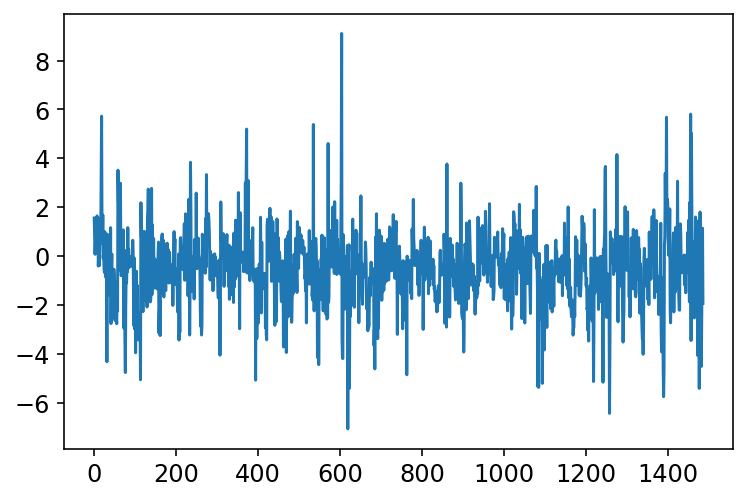

In [51]:
bias = env.get_bias()
plt.plot(bias)
m = bias.mean()
sd = bias.std()
print('bias mean:', m, '+1sd:', m+sd, '-1sd:', m-sd)

adjust:  (22,)
global adjust:  -3.150704273756117


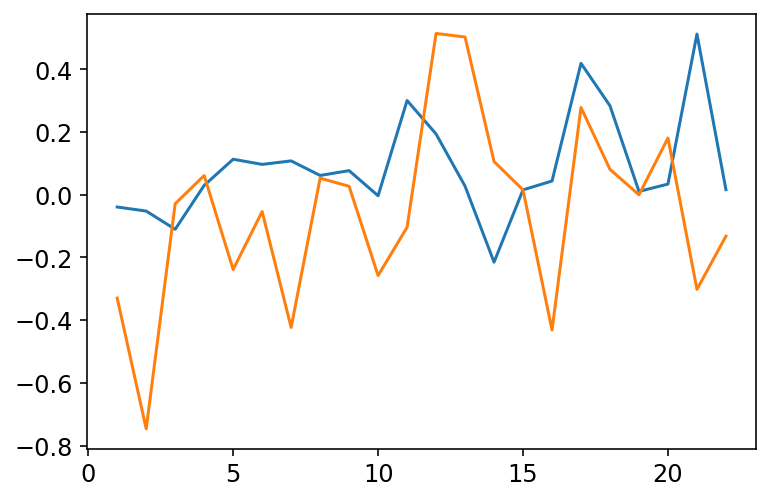

In [54]:
adjust = env.get_adjust()
print('global adjust: ', sum(adjust))
xan = np.diag(env.xm) + adjust
x = np.diag(env.xm)
plt.plot(range(1,23), x, label = 'prior')
plt.plot(range(1,23), xan, label = 'posterior')

shape of scaled y transpose:  (22, 1487)
SVD decomposition matrices: 
uy:  (22, 22)
wy:  (22,)
vyt:  (1487, 1487)
self.md:  (22,)
uw:  (22, 22)
y_inv_v: (22, 1487)
k:  (22, 1487)


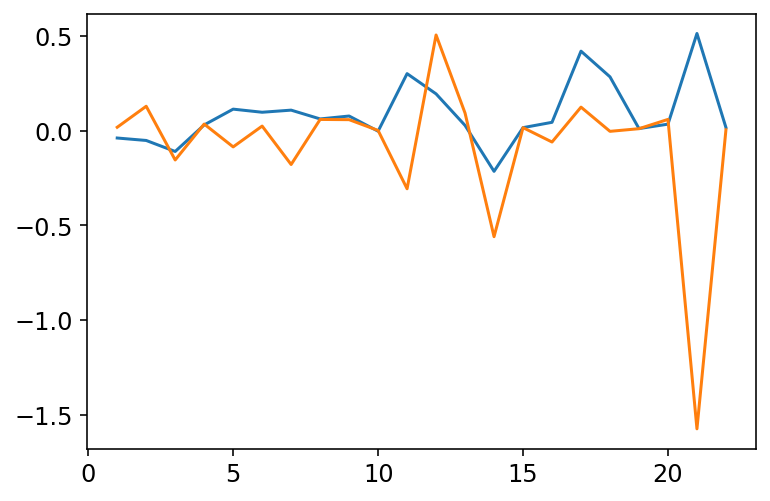

In [34]:
env.get_k_l()
xinc = np.dot(env.k, bias)
xan = np.diag(env.xm) + xinc
x = np.diag(env.xm)
plt.plot(range(1,23), x, label = 'prior')
plt.plot(range(1,23), xan, label = 'posterior')

In [25]:
tm = env.get_tm()

shape of scaled y transpose:  (22, 1487)
SVD decomposition matrices: 
uy:  (22, 22)
wy:  (22,)
vyt:  (1487, 1487)
self.md:  (22,)
uw:  (22, 22)
--------etkf: xtm, analysis increment on the variables--------
(22, 22)


shape of scaled y transpose:  (22, 1487)
SVD decomposition matrices: 
uy:  (22, 22)
wy:  (22,)
vyt:  (1487, 1487)
self.md:  (22,)
uw:  (22, 22)
y_inv_v: (22, 1487)
k:  (22, 1487)
xinc:  [ 0.05671059  0.1804343  -0.04483435  0.00469607 -0.19922193 -0.07290871
 -0.28685034 -0.00270026 -0.01918438  0.00397013 -0.60733182  0.31063378
  0.06509139 -0.34472566 -0.00001883 -0.10400246 -0.29526884 -0.28752998
 -0.00058079  0.0250296  -2.0858766  -0.0121235 ]
global update:  -3.716592584386601


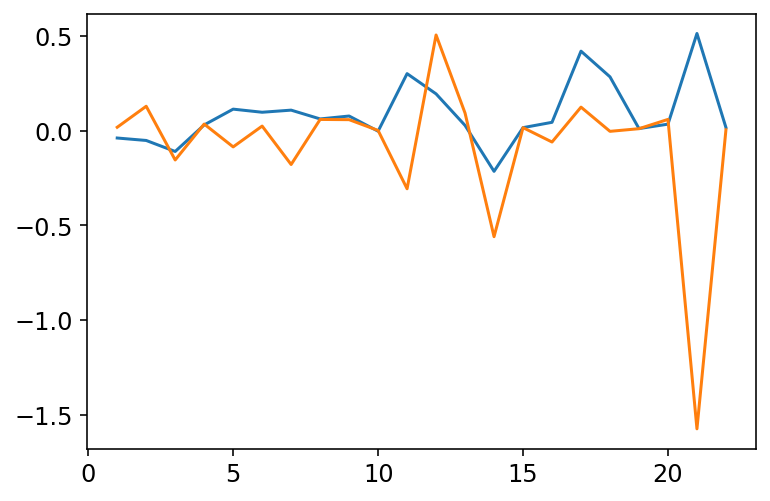

In [23]:
adjust_2 = env.get_inc_x()
plt.plot(range(1,23), monthly_net_flux[imonth - 1,:])
plt.plot(range(1,23), monthly_net_flux[imonth - 1,:] + adjust_2)

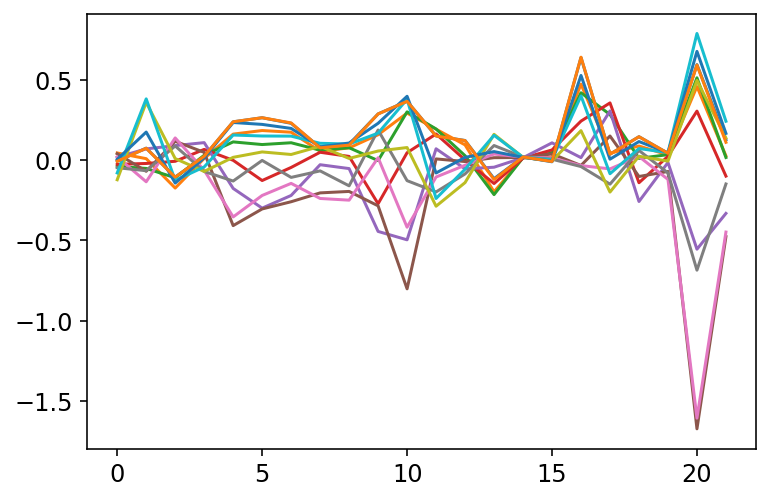

In [24]:
for i in range(12):
    plt.plot(monthly_net_flux[i,:])